In [1]:
if "google.colab" in str(get_ipython()):
    from google.colab import drive
    import os
    drive.mount("/content/gdrive")
    os.chdir("/content/gdrive/My Drive/CS4243 Project/temp")
    !pwd
    %pip install -q ipywidgets
    %pip install -q -r requirements_colab.txt
else:
    %pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Baseline (Multi-Layer Perceptron)

In [1]:
%reset

import torch
import torch.nn as nn

import numpy as np

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
from utils import load_tensor

train_x, train_y = load_tensor("unaug", "64", device)
test_x, test_y = load_tensor("test", "64", device)

train_x.size(), train_y.size()

(torch.Size([5500, 3, 64, 64]), torch.Size([5500]))

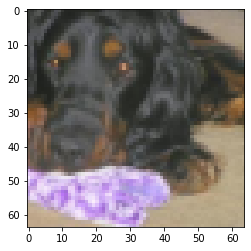

In [4]:
from utils import render_2d

idx = np.random.choice(train_x.size(0))
render_2d(train_x.cpu()[idx])

## Build MLP

In [6]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=5):
        super(MLP, self).__init__()
        assert num_layers >= 2

        self.layers = nn.ModuleList(
            [nn.Sequential(nn.Linear(input_size, hidden_size), nn.ReLU())]
            + [
                nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.ReLU())
                for i in range(2, num_layers)
            ]
            + [nn.Linear(hidden_size, output_size)]
        )
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [6]:
from utils import count_num_params

net = MLP(12288, 768, 10)
print(f"{count_num_params(net):,}")
net

11,217,418


MLP(
  (layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=12288, out_features=768, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=768, out_features=768, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=768, out_features=768, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=768, out_features=768, bias=True)
      (1): ReLU()
    )
    (4): Linear(in_features=768, out_features=10, bias=True)
  )
)

### Training

In [7]:
from utils import plot_experiments, run_experiments, save_results

def init_func():
    net = MLP(12288, 768, 10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(net.parameters(), lr=1e-4)

    return (net, criterion, optimizer)

df_unaug = run_experiments(init_func, (train_x, train_y), (test_x, test_y), (12288,))
save_results(df_unaug, "baseline_mlp", "unaug", "64")

  0%|          | 0/100 [00:00<?, ?it/s]

Experiment 0 (e4dee834):
epoch = 0	 loss = 2.220	 accuracy = 0.166	 test accuracy = 0.165
epoch = 10	 loss = 2.024	 accuracy = 0.271	 test accuracy = 0.253
epoch = 20	 loss = 1.875	 accuracy = 0.330	 test accuracy = 0.253
epoch = 30	 loss = 1.692	 accuracy = 0.407	 test accuracy = 0.255


  0%|          | 0/100 [00:00<?, ?it/s]

Experiment 1 (d6fe35b0):
epoch = 0	 loss = 2.222	 accuracy = 0.162	 test accuracy = 0.202
epoch = 10	 loss = 2.038	 accuracy = 0.260	 test accuracy = 0.243
epoch = 20	 loss = 1.900	 accuracy = 0.322	 test accuracy = 0.255
epoch = 30	 loss = 1.685	 accuracy = 0.409	 test accuracy = 0.250


  0%|          | 0/100 [00:00<?, ?it/s]

Experiment 2 (7c4f41cc):
epoch = 0	 loss = 2.225	 accuracy = 0.161	 test accuracy = 0.142
epoch = 10	 loss = 2.045	 accuracy = 0.265	 test accuracy = 0.228
epoch = 20	 loss = 1.897	 accuracy = 0.316	 test accuracy = 0.252
epoch = 30	 loss = 1.686	 accuracy = 0.414	 test accuracy = 0.243
epoch = 40	 loss = 1.403	 accuracy = 0.521	 test accuracy = 0.250


  0%|          | 0/100 [00:00<?, ?it/s]

Experiment 3 (a24cf640):
epoch = 0	 loss = 2.219	 accuracy = 0.164	 test accuracy = 0.142
epoch = 10	 loss = 2.032	 accuracy = 0.266	 test accuracy = 0.243
epoch = 20	 loss = 1.871	 accuracy = 0.334	 test accuracy = 0.252
epoch = 30	 loss = 1.677	 accuracy = 0.416	 test accuracy = 0.257


  0%|          | 0/100 [00:00<?, ?it/s]

Experiment 4 (04eb1f28):
epoch = 0	 loss = 2.221	 accuracy = 0.167	 test accuracy = 0.188
epoch = 10	 loss = 2.034	 accuracy = 0.260	 test accuracy = 0.227
epoch = 20	 loss = 1.871	 accuracy = 0.338	 test accuracy = 0.280
epoch = 30	 loss = 1.670	 accuracy = 0.415	 test accuracy = 0.237


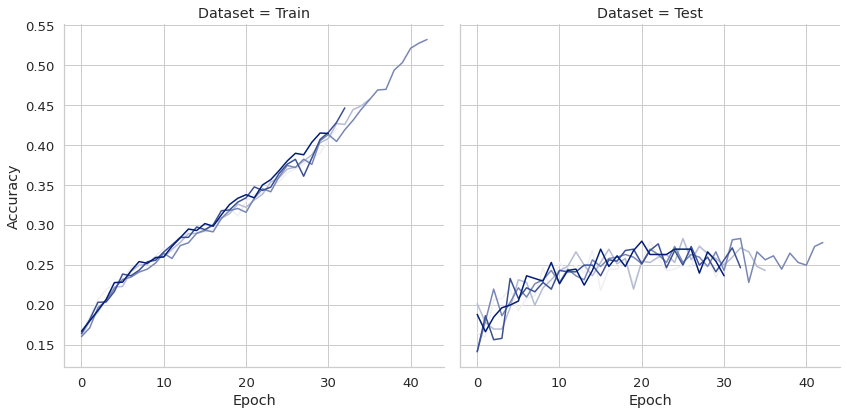

In [8]:
plot_experiments(df_unaug)

F1 Score : 0.2223999291218448
Precision: 0.2495159018380039
Recall   : 0.228054645906683


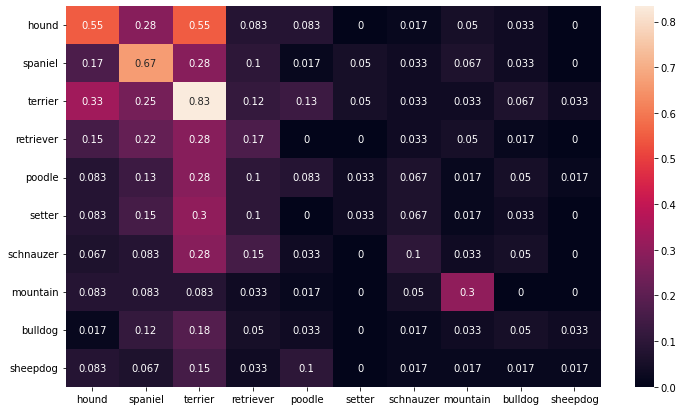

In [8]:
from utils import load_checkpoint, eval_test_accuracy, show_confusion_matrix, show_eval_metrics

net = MLP(12288, 768, 10).to(device)
load_checkpoint(net, "04eb1f28") # to be manually updated

accuracy, pred_y, true_y = eval_test_accuracy(net, (test_x, test_y), (12288,))

show_confusion_matrix(pred_y, true_y)
show_eval_metrics(pred_y, true_y)

### Training (with augmentation)

In [9]:
from utils import load_tensor

train_x, train_y = load_tensor("balan", "64", device)
train_x.size(), train_y.size()

(torch.Size([19509, 3, 64, 64]), torch.Size([19509]))

In [ ]:
from utils import render_2d

idx = np.random.choice(train_x.size(0))
render_2d(train_x.cpu()[idx])

  0%|          | 0/100 [00:00<?, ?it/s]

Experiment 0 (ac61a303):
epoch = 0	 loss = 2.269	 accuracy = 0.142	 test accuracy = 0.107
epoch = 10	 loss = 1.960	 accuracy = 0.302	 test accuracy = 0.213
epoch = 20	 loss = 1.566	 accuracy = 0.461	 test accuracy = 0.203


  0%|          | 0/100 [00:00<?, ?it/s]

Experiment 1 (d45fd75f):
epoch = 0	 loss = 2.272	 accuracy = 0.138	 test accuracy = 0.108
epoch = 10	 loss = 1.983	 accuracy = 0.292	 test accuracy = 0.185
epoch = 20	 loss = 1.563	 accuracy = 0.462	 test accuracy = 0.222
epoch = 30	 loss = 1.097	 accuracy = 0.630	 test accuracy = 0.215


  0%|          | 0/100 [00:00<?, ?it/s]

Experiment 2 (8c7a1066):
epoch = 0	 loss = 2.270	 accuracy = 0.141	 test accuracy = 0.118
epoch = 10	 loss = 1.967	 accuracy = 0.298	 test accuracy = 0.182


  0%|          | 0/100 [00:00<?, ?it/s]

Experiment 3 (d1f5ff8f):
epoch = 0	 loss = 2.270	 accuracy = 0.140	 test accuracy = 0.115
epoch = 10	 loss = 1.953	 accuracy = 0.305	 test accuracy = 0.212
epoch = 20	 loss = 1.538	 accuracy = 0.471	 test accuracy = 0.197


  0%|          | 0/100 [00:00<?, ?it/s]

Experiment 4 (eed4ef41):
epoch = 0	 loss = 2.274	 accuracy = 0.138	 test accuracy = 0.132
epoch = 10	 loss = 1.974	 accuracy = 0.295	 test accuracy = 0.232
epoch = 20	 loss = 1.562	 accuracy = 0.458	 test accuracy = 0.202


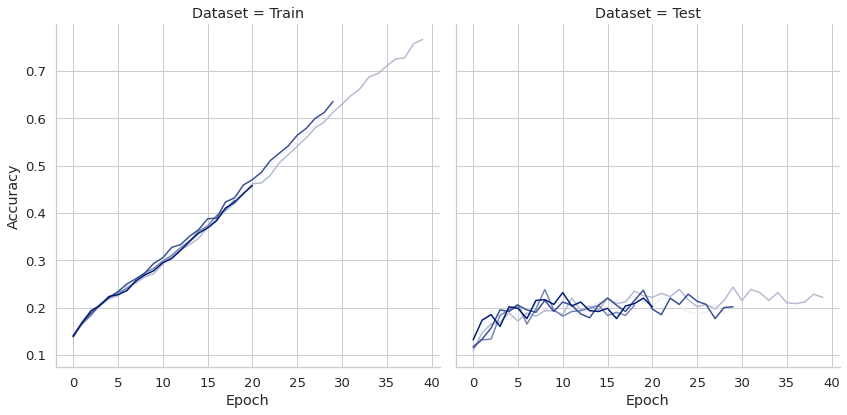

In [10]:
from utils import plot_experiments, run_experiments, save_results

def init_func():
    net = MLP(12288, 768, 10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(net.parameters(), lr=1e-4)

    return (net, criterion, optimizer)

df_balan = run_experiments(init_func, (train_x, train_y), (test_x, test_y), (12288,))
save_results(df_balan, "baseline_mlp", "balan", "64")

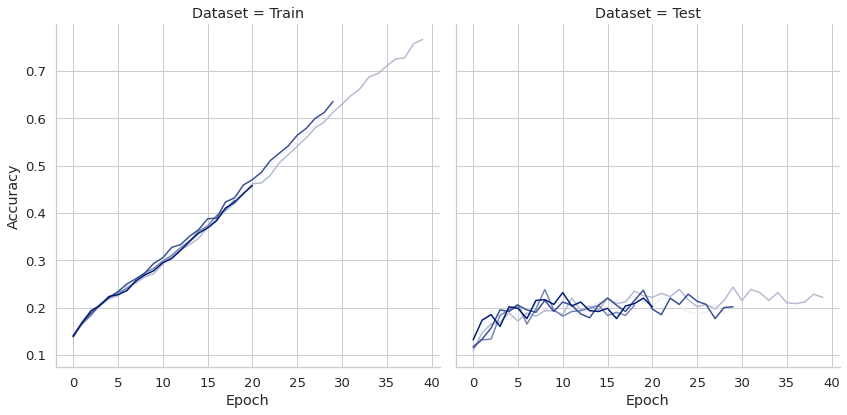

In [11]:
plot_experiments(df_balan)

F1 Score : 0.19292387644150152
Precision: 0.21072294623106796
Recall   : 0.2208343498513318


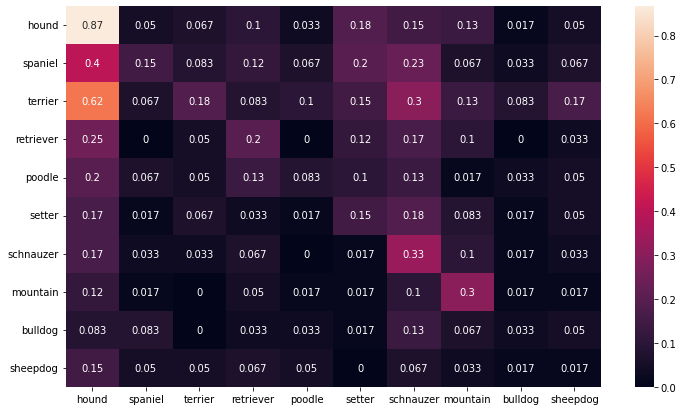

In [9]:
from utils import load_checkpoint, eval_test_accuracy, show_confusion_matrix, show_eval_metrics

net = MLP(12288, 768, 10).to(device)
load_checkpoint(net, "eed4ef41") # to be manually updated

accuracy, pred_y, true_y = eval_test_accuracy(net, (test_x, test_y), (12288,))

show_confusion_matrix(pred_y, true_y)
show_eval_metrics(pred_y, true_y)